# **Covid 19: elders situation**

In [0]:
import pandas as pd
import numpy as np
import github
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
dark_theme = False
if dark_theme:
    plt.style.use(['dark_background'])
    plt.rcParams['figure.facecolor'] = ".22"
    plt.rcParams["axes.facecolor"] = ".22"
else:
    plt.style.use(['default'])
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 2

## **Loading the Microsoft Bing covid 19 dataset**

In [0]:
import github
from helpers import get_covid_19_data, get_elders_hosp_share

for item in github.Github().get_repo("microsoft/Bing-COVID-19-Data").get_contents("data/"):
    if "csv" in item.name:  # Making the assumption (still ok up to now) that there is one csv only
        csv_name = item.name
bing_data = pd.read_csv("https://raw.githubusercontent.com/microsoft/Bing-COVID-19-Data/master/data/"+csv_name)

# Ministère de la Santé data for date 04/23/2020 (from the dataset retrieved below)
add_map_France = {
    'France (ehpad)':30.1,
    'France (hospital)':14.6
}

date_ = '04/23/2020'

bing_data_latest_by_country = get_covid_19_data(bing_data, date_, min_cases=10000, ref_country='South Korea', add_map=add_map_France)

# Loading the MS Bing covid 19 time series
bing_data_by_country = get_covid_19_data(bing_data, None)

## **Showing the deaths overs confirmed cases share per country**

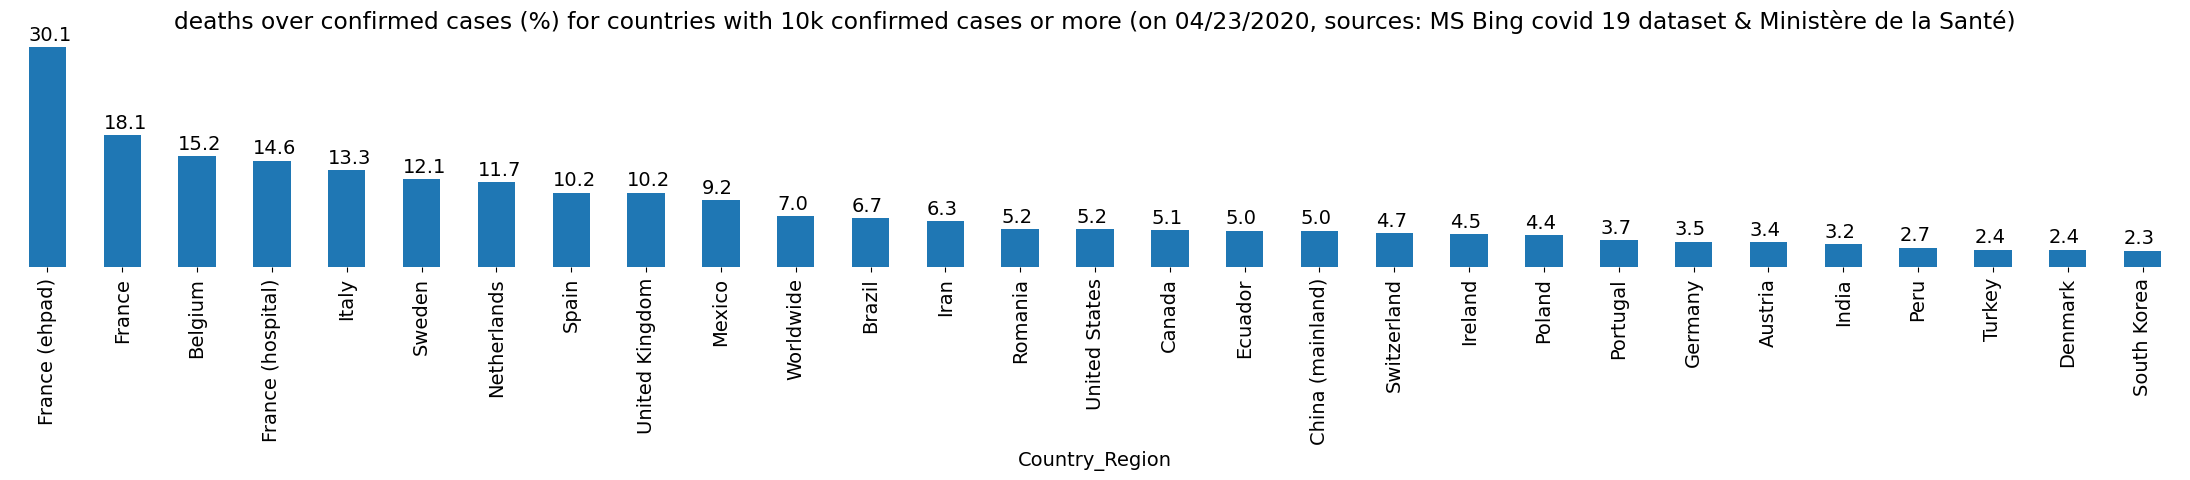

In [25]:
# Sorting the value
bing_data_latest_by_country_ = bing_data_latest_by_country[['death rate']].copy()
bing_data_latest_by_country_.sort_values(by='death rate', ascending=False, inplace=True)

# Plotting the data
ax = bing_data_latest_by_country_['death rate'].plot.bar(
    title='deaths over confirmed cases (%) for countries with 10k confirmed cases or more (on ' + date_ + ', sources: MS Bing covid 19 dataset & Ministère de la Santé)', 
    figsize=(28,3)
)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.0, p.get_height() + 1.0))
for p in ['top', 'left', 'bottom', 'right']:
    ax.axes.spines[p].set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.show()

## **Showing the deaths overs confirmed cases share per country over time**

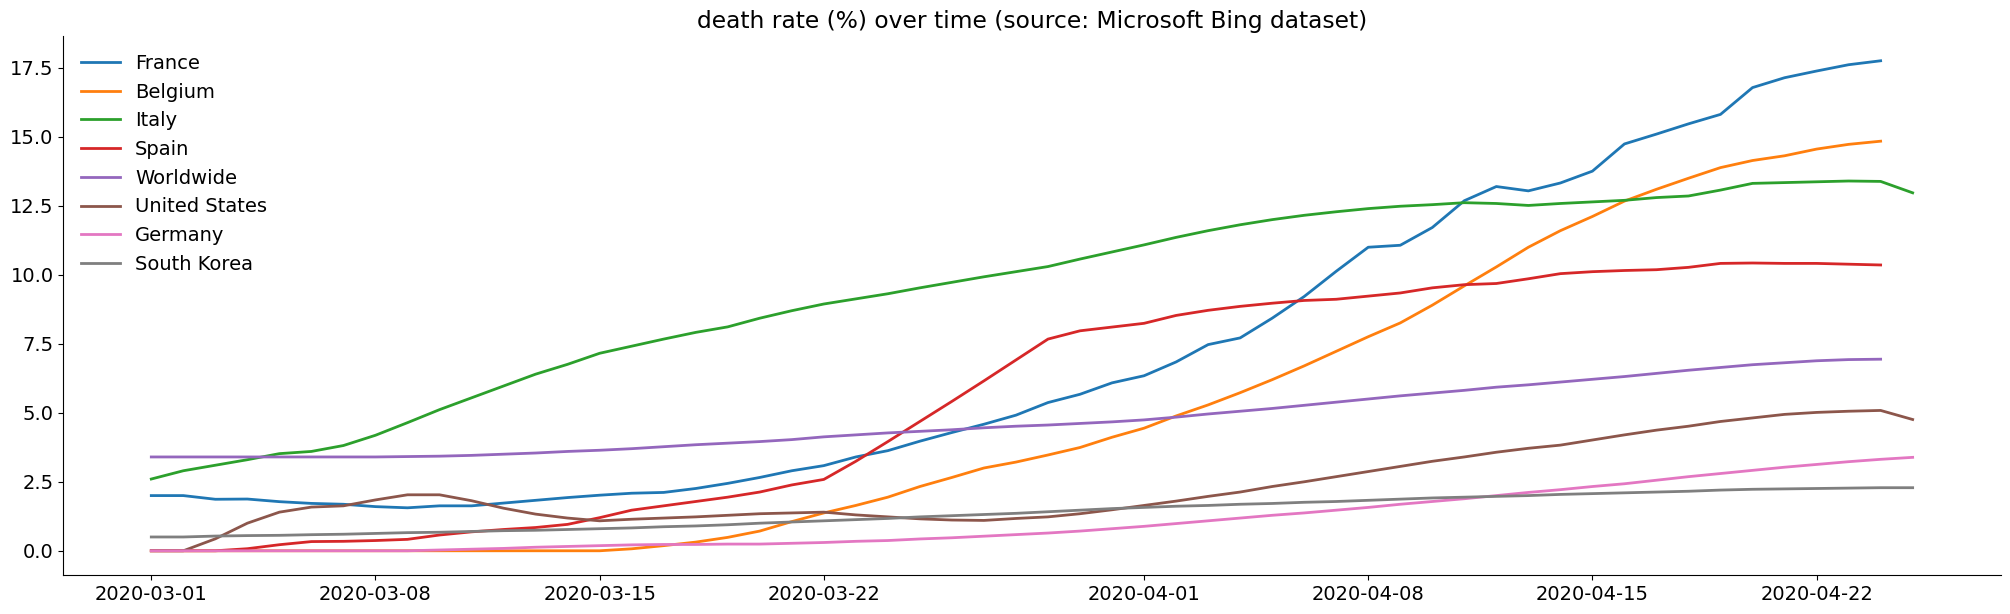

In [26]:
import matplotlib.dates as mdates

country_set = ['France', 'Belgium', 'Italy', 'Spain', 'Worldwide', 
               'United States', 'Germany', 'South Korea']

rolling_param = 7

plt.figure(figsize=(25,7))

for country in country_set:
    bing_data_country = bing_data_by_country.loc[country].copy()
    bing_data_country = bing_data_country.set_index('Updated')
    bing_data_country.index = pd.to_datetime(bing_data_country.index)
    bing_data_country_ = bing_data_country[bing_data_country.index.month >= 3]
    bing_data_country_ = bing_data_country_.rolling(rolling_param, min_periods=1).mean()

    ax_country = plt.plot(bing_data_country_['death rate'], label=country)[0]

    for p in ['top', 'right']:
        ax_country.axes.spines[p].set_visible(False)

plt.title(label='death rate (%) over time (source: Microsoft Bing dataset)')
plt.legend(loc='upper left', frameon=False)
plt.show()

## **French institutions dataset**

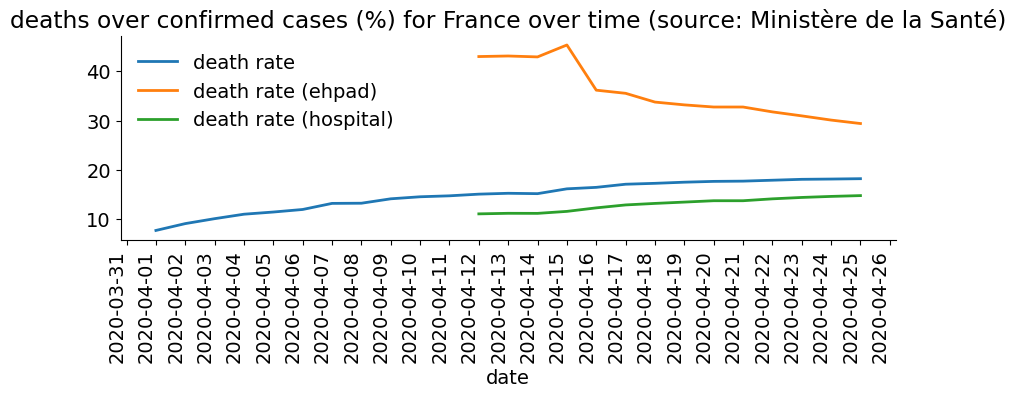

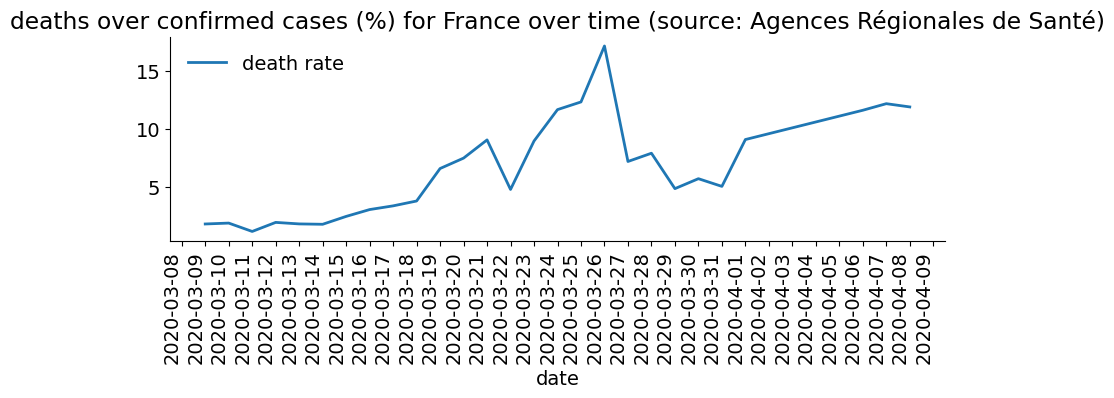

In [27]:
# Could be improved (factorization at least)
import matplotlib.dates as mdates

min_cases = 1000

# Loading the opencovid19-fr dataset
data_gouv_France = pd.read_csv("https://raw.githubusercontent.com/opencovid19-fr/data/master/dist/chiffres-cles.csv")

# Selecting the Ministère de la Santé dataset which includes the so-called EHPAD
data_gouv_France_ephad = data_gouv_France[
            (data_gouv_France['granularite']=='pays') & 
            (data_gouv_France['source_type']=='ministere-sante')]

# Selecting the Agences Régionales de Santé dataset
data_gouv_France = data_gouv_France[
            (data_gouv_France['granularite']=='region') & 
            (data_gouv_France['source_type']=='agences-regionales-sante')]

selection_set = ['date', 'maille_nom', 'deces', 'deces_ehpad', 'cas_confirmes', 'cas_confirmes_ehpad']

# Ministère de la Santé dataset
data_gouv_France_ephad = data_gouv_France_ephad[selection_set].copy()
data_gouv_France_ephad = data_gouv_France_ephad[data_gouv_France_ephad['cas_confirmes'] >= min_cases]
# Getting things clearer ("deces" stands for "deces_hospital")
data_gouv_France_ephad['deces_hospital'] = data_gouv_France_ephad['deces']
data_gouv_France_ephad['deces'] = data_gouv_France_ephad['deces'] + data_gouv_France_ephad['deces_ehpad']
# Computing the deaths over confirmed cases share
data_gouv_France_ephad['death rate'] = (
    data_gouv_France_ephad['deces'] / data_gouv_France_ephad['cas_confirmes'] * 100.0
)
data_gouv_France_ephad['death rate (ehpad)'] = (
    data_gouv_France_ephad['deces_ehpad'] / data_gouv_France_ephad['cas_confirmes_ehpad'] * 100.0
)
data_gouv_France_ephad['death rate (hospital)'] = (
    data_gouv_France_ephad['deces_hospital'] / (
    data_gouv_France_ephad['cas_confirmes'] - data_gouv_France_ephad['cas_confirmes_ehpad']
    ) * 100.0
)
# Setting the date as the index and filling NA values according to the ffill method
data_gouv_France_ephad.set_index('date', drop=True, inplace=True)
data_gouv_France_ephad.index = pd.to_datetime(data_gouv_France_ephad.index)
data_gouv_France_ephad.fillna(method='ffill', inplace=True)

# Plotting the results
ax_France_ehpad = data_gouv_France_ephad[['death rate', 'death rate (ehpad)', 'death rate (hospital)']].plot(figsize=(10,3))
for p in ['top', 'right']:
    ax_France_ehpad.axes.spines[p].set_visible(False)
plt.xticks(rotation=90)
plt.axes().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.title(label='deaths over confirmed cases (%) for France over time (source: Ministère de la Santé)')
plt.legend(loc='upper left', frameon=False)

# Agences Régionales de Santé dataset
data_gouv_France_ = data_gouv_France[selection_set].copy()
data_gouv_France_gb = data_gouv_France_.groupby('date')
data_gouv_France_deces = data_gouv_France_gb['deces'].sum().reset_index(name='deces')
data_gouv_France_confirmes = data_gouv_France_gb['cas_confirmes'].sum().reset_index(name='cas_confirmes')
data_gouv_France_all = data_gouv_France_deces.merge(data_gouv_France_confirmes)
data_gouv_France_all = data_gouv_France_all[data_gouv_France_all['cas_confirmes'] >= min_cases]
# Computing the deaths over confirmed cases share
data_gouv_France_all['death rate'] = data_gouv_France_all['deces'] / data_gouv_France_all['cas_confirmes'] * 100.0
# Setting the date as the index
data_gouv_France_all.set_index('date', drop=True, inplace=True)
data_gouv_France_all.index = pd.to_datetime(data_gouv_France_all.index)

# Plotting the results
ax_France_ = data_gouv_France_all[['death rate']].plot(figsize=(10,3))
for p in ['top', 'right']:
    ax_France_.axes.spines[p].set_visible(False)
plt.xticks(rotation=90)
plt.axes().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.title(label='deaths over confirmed cases (%) for France over time (source: Agences Régionales de Santé)')
plt.legend(loc='upper left', frameon=False)

plt.show()

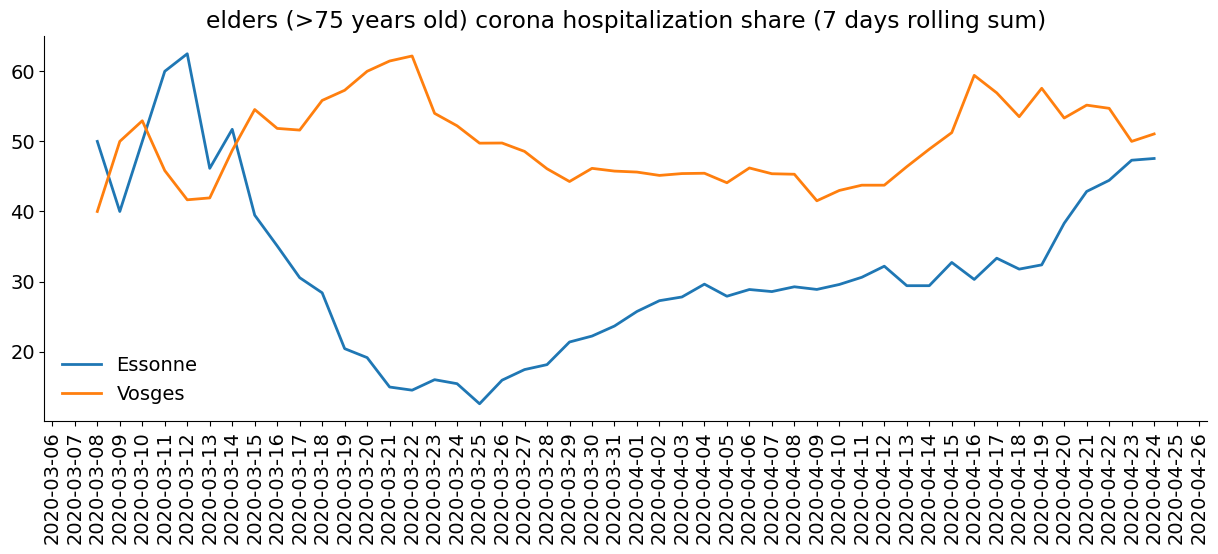

In [28]:
data_by_age = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/eceb9fb4-3ebc-4da3-828d-f5939712600a")

selection_set = ['dep', 'date_de_passage', 'nbre_pass_corona', 'nbre_hospit_corona', 'nbre_acte_corona']

dep_map = {
    'Essonne':['91'],
    'Vosges':['88']
}

plt.figure(figsize=(15,5))

for key, dep_set in dep_map.items():
    data_by_age_idf = data_by_age[data_by_age['dep'].isin(dep_set)].copy()
    data_elders_hosp_share = get_elders_hosp_share(data_by_age_idf, rolling=rolling_param)
    data_elders_hosp_share = data_elders_hosp_share[
        (data_elders_hosp_share.index.month>3) | (data_elders_hosp_share.index.day>=8)
    ]
    plot_ = plt.plot(data_elders_hosp_share['elders corona hosp. share'], label=key)[0]
    for p in ['top', 'right']:
        plot_.axes.spines[p].set_visible(False)

plt.xticks(rotation=90)
plt.axes().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.title(label='elders (>75 years old) corona hospitalization share (7 days rolling sum)')
plt.legend(loc='bottom left', frameon=False)
plt.show();